In [1]:
import cnmfsns as cn
cn.start_logging()

2023-06-08 10:07:20,502 [INFO] cNMF-SNS version 1.0.12


## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [7]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [3]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad", patient_id_col="patient_id")  # read a .h5ad file

2023-05-03 09:08:39,740 [INFO] Writing to c:\Users\verhe\github\cNMF-SNS\tutorial\diamandis.h5ad
2023-05-03 09:08:39,791 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [4]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [5]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

## Modelling mean and dispersion of genes

In [6]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252149,1.839333e+07,False,0.090639,1.109992,14.161509,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368913,16.357670,2.338366e+08,False,0.040062,1.047204,16.317608,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974915,2.478940e+06,False,-0.186995,0.806311,12.161909,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684864e+14,3.112051e+07,0.0,8.029284,14.986094,1.069756e+08,False,-0.652042,0.472040,15.638136,0.763087


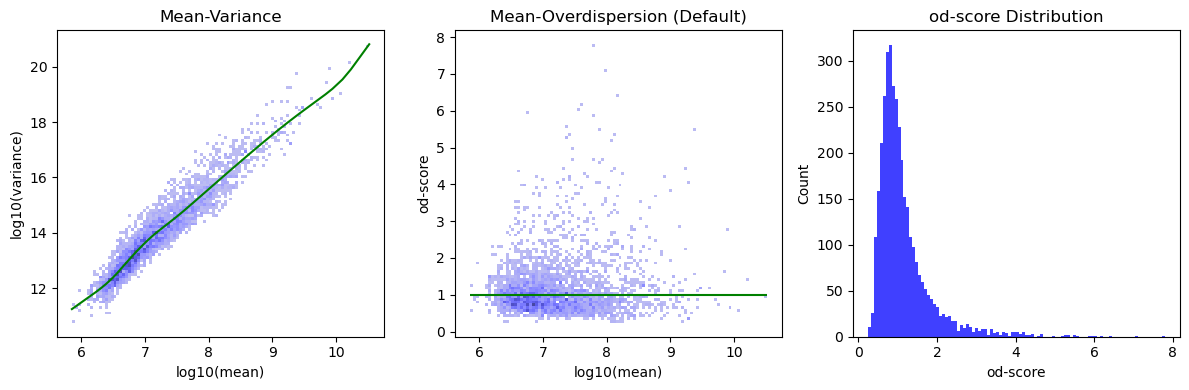

In [7]:
figs = cn.plot_feature_dispersion(diamandis)

## Selecting overdispersed genes

2023-05-03 09:08:41,859 [INFO] 1612 genes selected for factorization


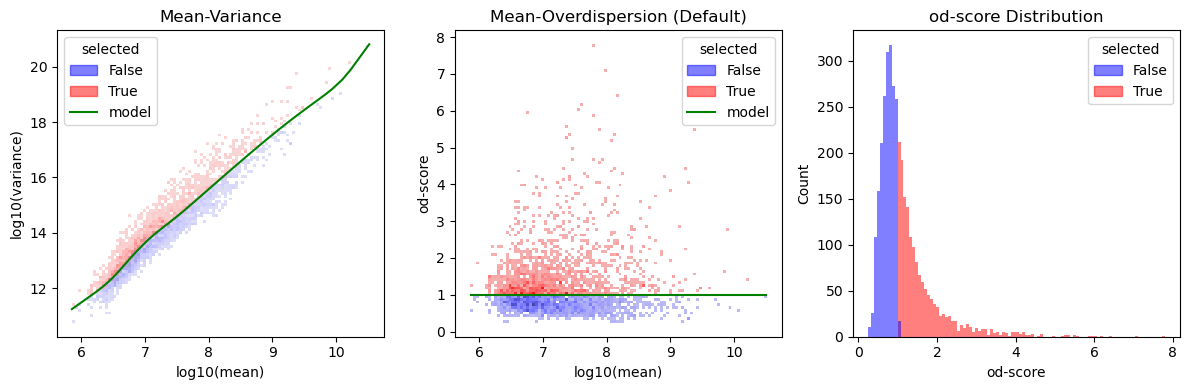

In [8]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [9]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [ ]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)


# these steps take long

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

## Stability-Error Plot

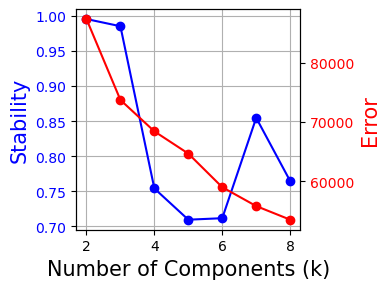

In [11]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [12]:
diamandis.get_usages()

2                       3                           \
                   1           2           1           2            3   
sample_1   286039.00  68284.7660  275501.340  52171.9300   35588.8750   
sample_10  275184.16  43295.9570  223846.840  31139.1290   67099.0550   
sample_11  303857.88  47271.9530  314491.400  32460.6130   17056.7340   
sample_12  325115.20  25503.4940  351295.200  10049.3510    5759.7524   
sample_13  322499.56  10377.7860  272781.750   3187.1445   62960.8550   
...              ...         ...         ...         ...          ...   
sample_75  381373.80   4573.6520   17812.012   2299.0654  333054.7800   
sample_76  340695.80   7992.3890   69184.445   4397.6410  252775.1900   
sample_77  375878.66   5628.8896   33456.980   3976.5266  313711.0600   
sample_8   295884.00  26063.9790  304175.000  12205.6150   18440.1170   
sample_9   353076.16  24305.6110  359185.030  11702.3290   21105.4510   

                    4                                                 5  ...  \
                    1           2            3            4           1  ...   
sample_1   235414.690  36155.5700   28776.5980   65348.1950  184611.600  ...   
sample_10  185804.440  18583.4920   60268.8870   62972.6800  126564.390  ...   
sample_11  295804.470  28362.2130   12586.2470   13678.9300  146371.170  ...   
sample_12  333022.500   9500.3270    2951.0034    5766.5796   28832.562  ...   
sample_13  254180.970   1453.5305   57558.7970   17758.3320  192837.380  ...   
...               ...         ...          ...          ...         ...  ...   
sample_75   23103.734   1204.6897  325858.6600    3045.1235   15878.019  ...   
sample_76   68754.625   1911.0745  243246.3300   13058.8410   44626.914  ...   
sample_77   40684.555   2202.6338  303112.2200    5420.9263   11156.094  ...   
sample_8   229307.690    969.4932   10174.5470  109044.8300  224094.830  ...   
sample_9   342468.100  11065.5750   16508.8980    5669.4526  116274.480  ...   

                    7                         8                            \
                    6           7             1            2            3   
sample_1    50491.414   6774.7140  32710.178000   50357.3480  199259.8600   
sample_10   20379.270   1640.9398  15699.491000   39035.8160  165451.6200   
sample_11   25460.844   6389.0530  27905.531000  210644.5000   23891.4690   
sample_12  256005.660   3259.6630   2674.429200   58214.7340   11915.4160   
sample_13   26582.346   2141.1538    681.331400  137070.6000   81304.3900   
...               ...         ...           ...          ...          ...   
sample_75    4791.499   1664.0808   1451.138500   19675.0920    6102.2056   
sample_76    6632.422    941.6223   1325.782700   34107.1170   56316.7700   
sample_77    6215.871   1331.6658     60.146503    1553.1504    1451.9280   
sample_8    25953.627  13894.6470   1170.722500   65570.3000  229911.9400   
sample_9    70827.050   3817.4521   9311.708000  244897.8800   17484.8280   

                                                                             
                      4           5             6             7           8  
sample_1    10874.81000  45399.9900   44903.72300    9622.72500  4340.76460  
sample_10   17092.79300   9520.1610   13204.77000   90211.00000  1562.53000  
sample_11    8933.53300  15348.3730   21597.30700   28596.34000  4746.70100  
sample_12    1155.95400  15884.5400  249662.12000     230.25110  2201.30030  
sample_13   45931.32400  42263.0000   23216.48000    8008.29150  1269.42400  
...                 ...         ...           ...           ...         ...  
sample_75  295753.62000  24251.2500    4517.90620    3577.59180  1442.64360  
sample_76  215442.39000   4890.6733    5326.53500   21841.91800   716.55010  
sample_77  220634.16000   1874.3624     595.71436  125215.61000   465.64612  
sample_8      793.84247  51962.2800   20480.37500     169.94676  8649.01100  
sample_9    16357.59400   9392.5200   66335.64000     653.24130  2050.26680  

[77 rows x 

2023-05-03 09:09:08,965 [INFO] Choosing distinct colors for metadata layer patient_id
2023-05-03 09:09:09,261 [INFO] Choosing distinct colors for metadata layer simple_category
2023-05-03 09:09:09,297 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-05-03 09:09:09,331 [INFO] Choosing distinct colors for metadata layer sex
2023-05-03 09:09:09,343 [INFO] Choosing distinct colors for metadata layer location of resection
2023-05-03 09:09:09,519 [INFO] Choosing distinct colors for metadata layer ATRX
2023-05-03 09:09:09,532 [INFO] Choosing distinct colors for metadata layer p53
2023-05-03 09:09:09,552 [INFO] Choosing distinct colors for metadata layer MGMT


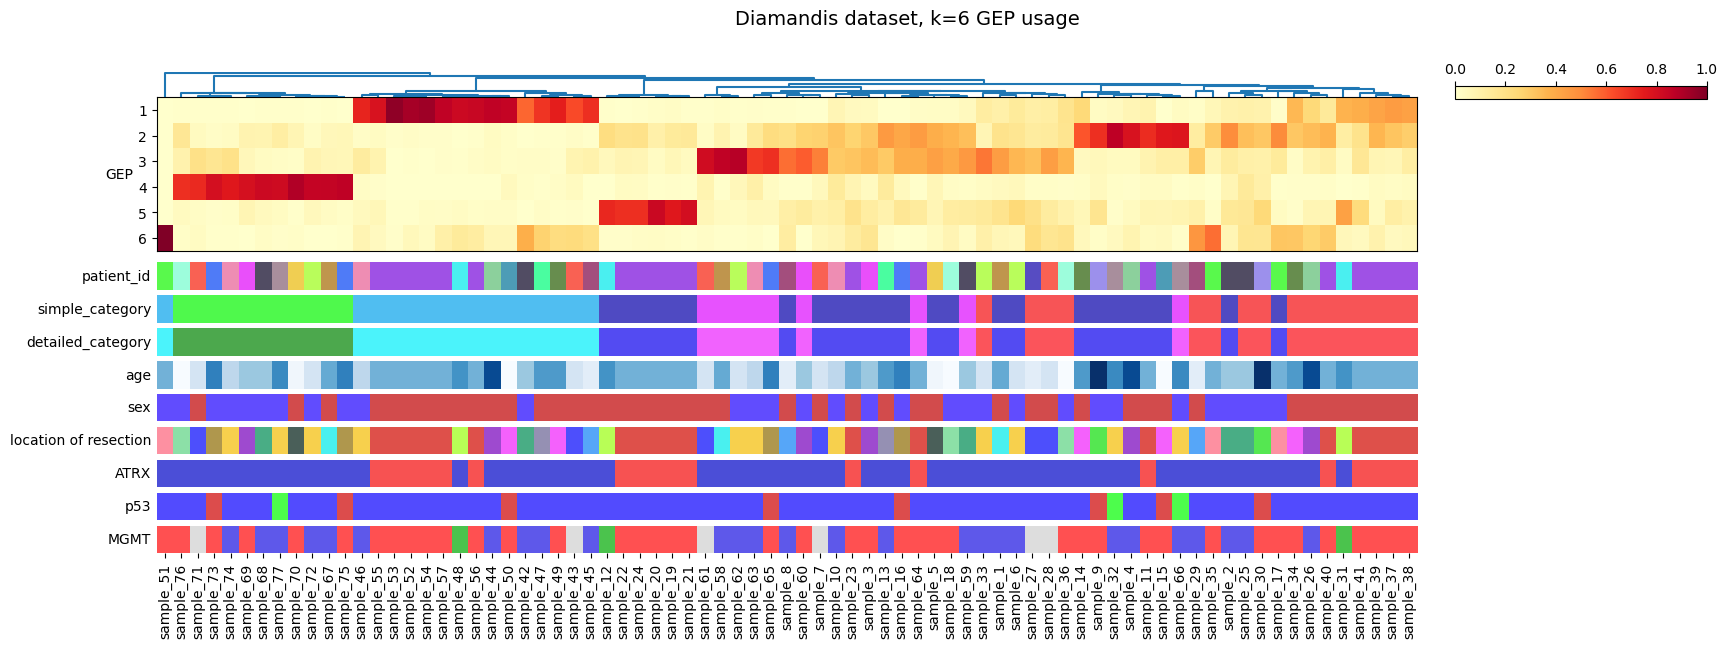

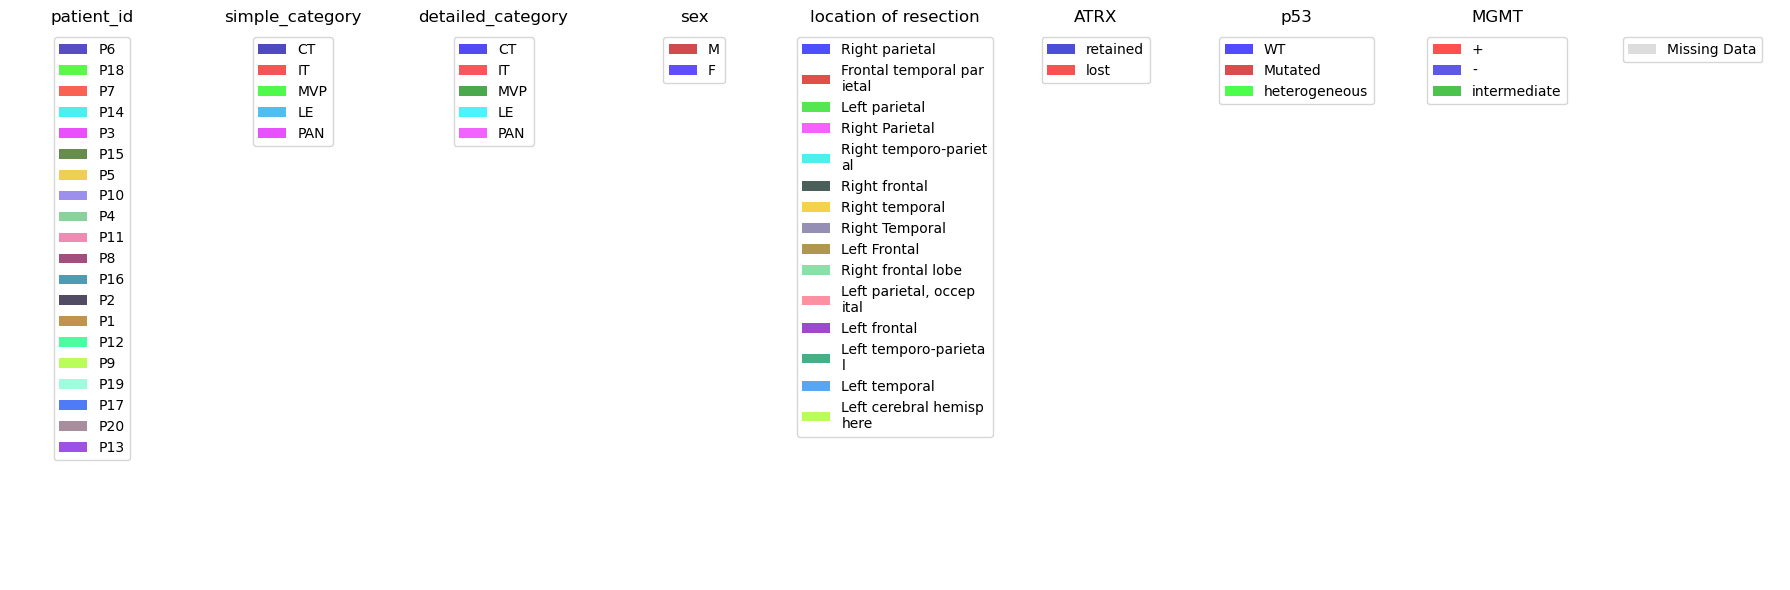

In [13]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [ ]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

## Integrate multiple datasets together

In [15]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-05-03 09:11:11,794 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.
2023-05-03 09:11:21,107 [INFO] Choosing distinct dataset colors
2023-05-03 09:11:21,138 [INFO] Choosing distinct colors for metadata layer patient_id
2023-05-03 09:11:31,008 [INFO] Choosing distinct colors for metadata layer simple_category
2023-05-03 09:11:31,034 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-05-03 09:11:31,062 [INFO] Choosing distinct colors for metadata layer multiomic
2023-05-03 09:11:31,095 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-05-03 09:11:31,131 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-05-03 09:11:31,197 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-05-03 09:11:31,338 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-05-03 09:11:31,356 [INFO] Choosing distinct colors for metadata layer immune
2023-05-03 09:11:31,392 [INFO] Choosing di

In [16]:
integration.k_subset

(2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60)

Identify gene overlap between datasets

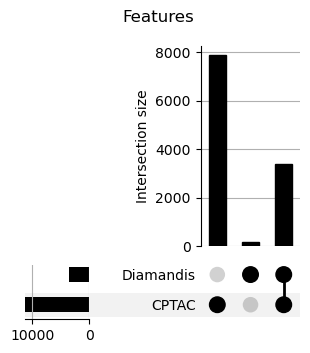

In [17]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

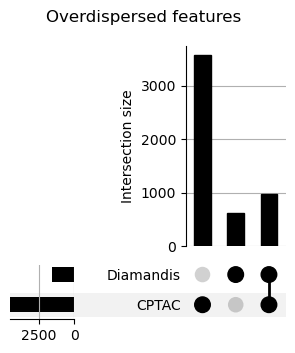

In [18]:
cn.plot_overdispersed_features_upset(integration)

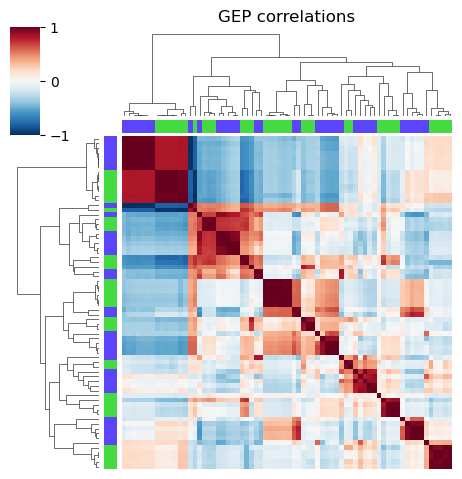

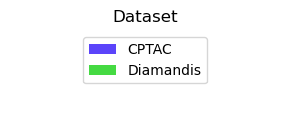

In [19]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [20]:
integration.k_table

CPTAC                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991490    297180.125000       True   
3        True              True         -0.460002    271649.406250       True   
4        True              True         -0.301157    255599.765625       True   
5        True              True         -0.211197    241667.421875       True   
6        True              True         -0.145935    232911.750000       True   
7        True              True         -0.134166    228262.156250       True   
8        True              True         -0.143855    221709.656250       True   

              Diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.989291        True              True         -0.999227     87360.250000   
3  0.897761        True              True         -0.439675     73714.195312   
4  0.699742        True              True         -0.218415     68420.468750   
5  0.686324        True              True         -0.207442     64667.148438   
6  0.578792        True              True         -0.166570     58997.570312   
7  0.480740        True              True         -0.136993     55817.187500   
8  0.440837        True              True         -0.122139     53522.109375   

                        
  selected_k stability  
2       True  0.995220  
3       True  0.984966  
4       True  0.753903  
5       True  0.709461  
6       True  0.711581  
7       True  0.854483  
8       True  0.764500

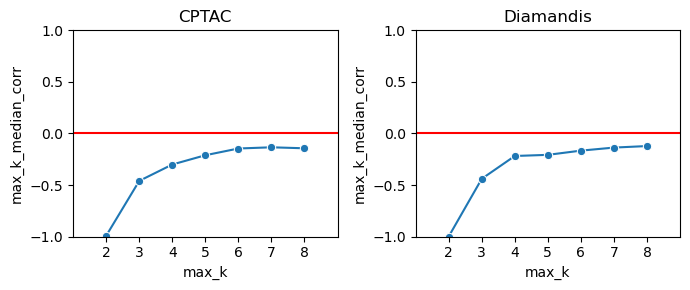

In [21]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

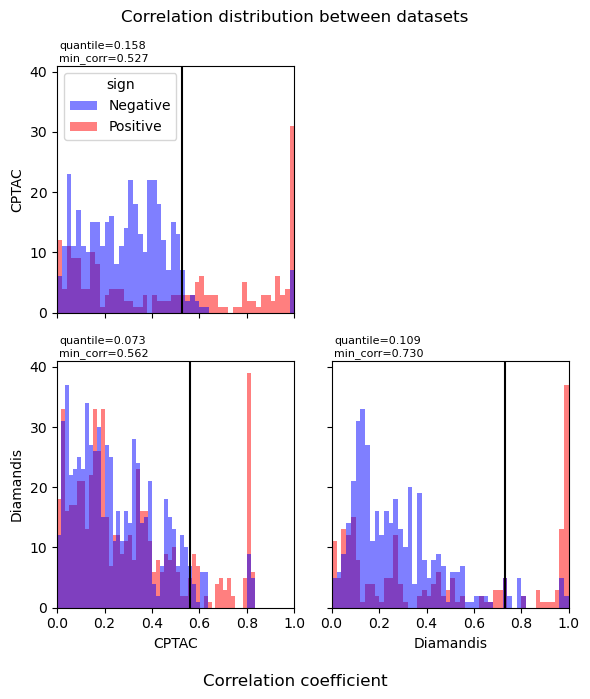

In [22]:
# fig = cn.plot_pairwise_corr(integration)
fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [23]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         35      35   35      35        35      35
Diamandis     35      35   35      35        35      35

## Create an SNS integration

2023-05-03 09:11:37,020 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-05-03 09:11:37,035 [INFO] Creating community network


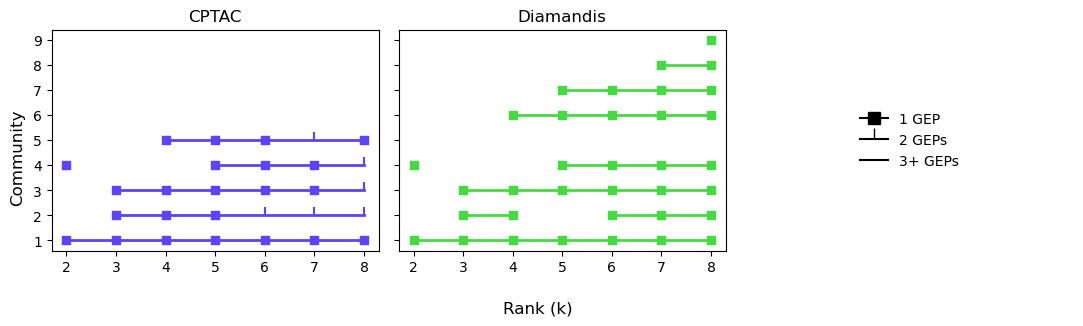

In [24]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

## Prune communities with only 1 node

2023-05-03 09:11:37,774 [INFO] Creating community network


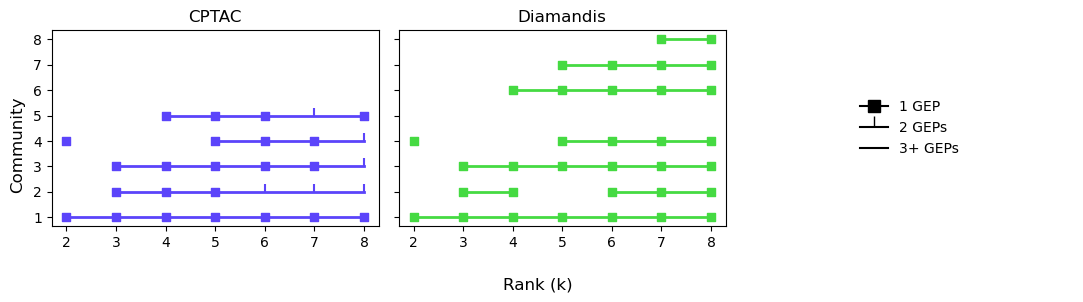

In [25]:
snsmap.prune_communities(min_nodes = 2)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

## Save SNS object and underlying data

In [26]:
snsmap.to_pkl("sns.pkl")

# to read it back, use this
snsmap = cn.SNS.from_pkl("sns.pkl")

# Plot an SNS Map

2023-05-03 09:11:38,998 [INFO] Computing community layout using centroid method.


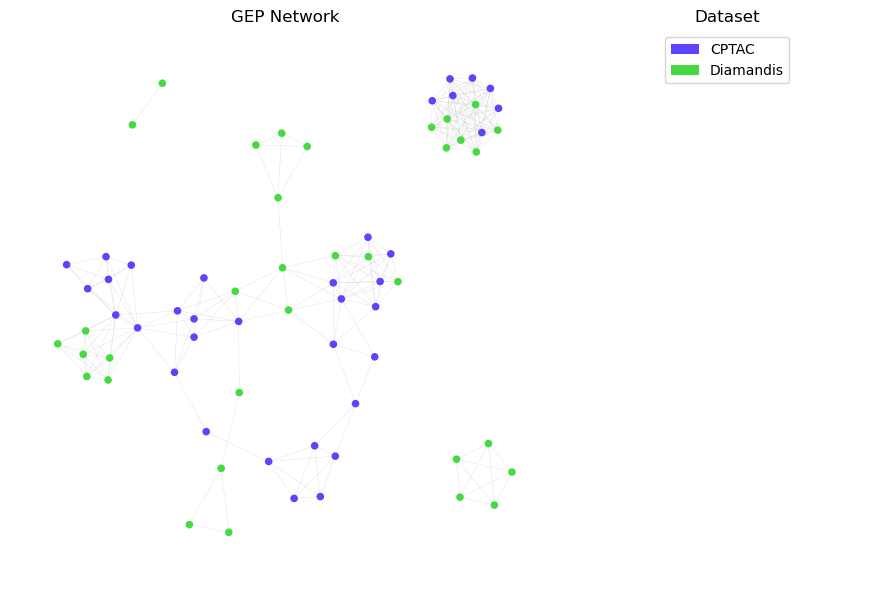

In [27]:
snsmap.compute_layout(algorithm="neato", community_layout_algorithm="centroid")  # available algorithms: "community_weighted_spring", "spring", "neato"
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

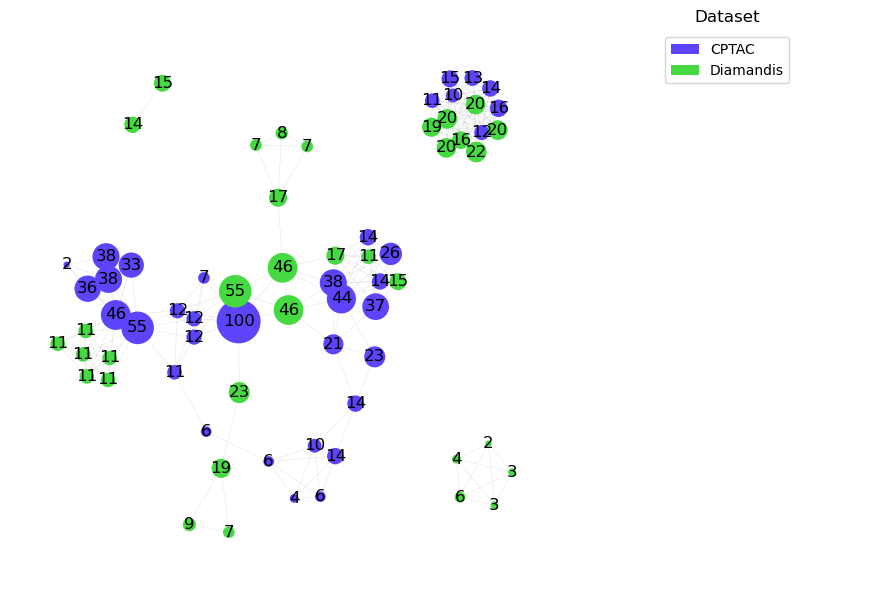

In [28]:
fig = cn.plot_gep_network_nsamples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

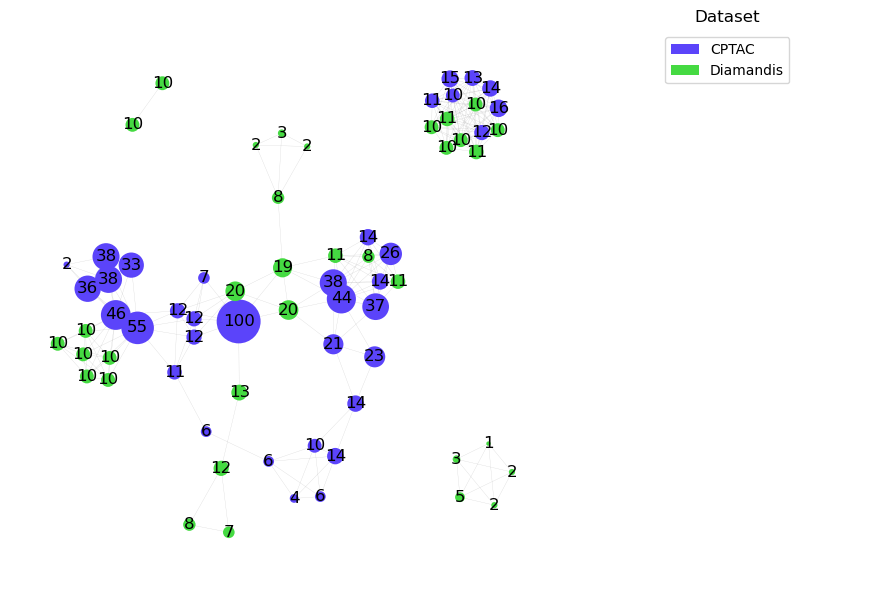

In [29]:
fig = cn.plot_gep_network_npatients(snsmap, colors, node_size=1e3, font_size=12)


Overrepresentation of sample categories for each GEP on the network

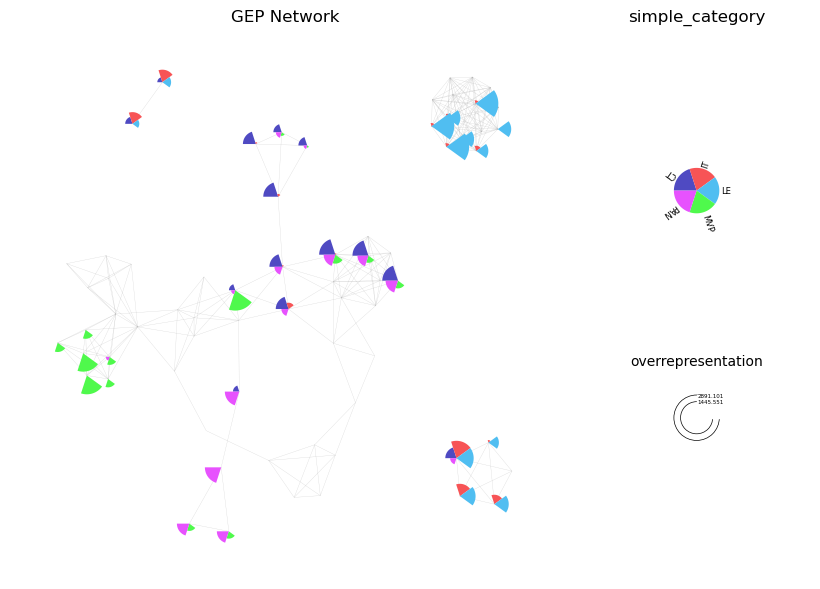

In [30]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

And again, using the CPTAC annotations

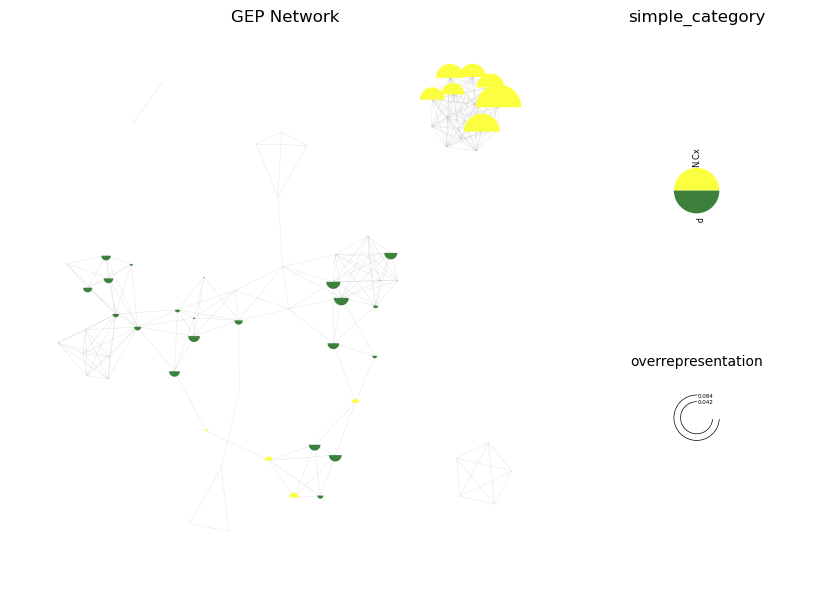

In [31]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

You can also look at continuous metadata correlated with GEP usage, like age:

# Identifying GEP Communities

2023-05-03 09:11:42,414 [INFO] Choosing distinct community colors


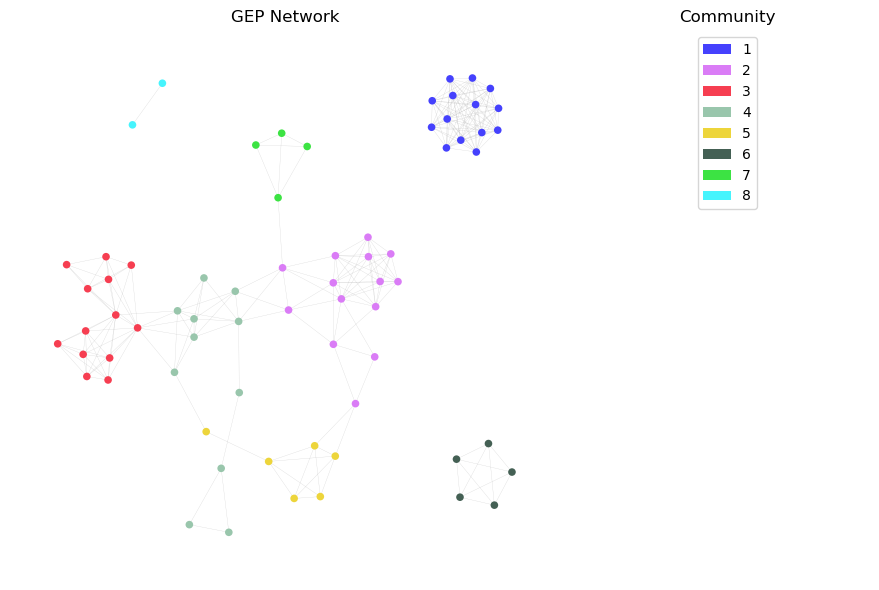

In [32]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

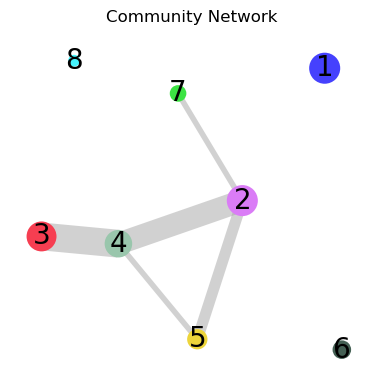

In [33]:
fig = cn.plot_summary_community_network(snsmap, colors)

Plot GEP usage heatmap summarized by Community

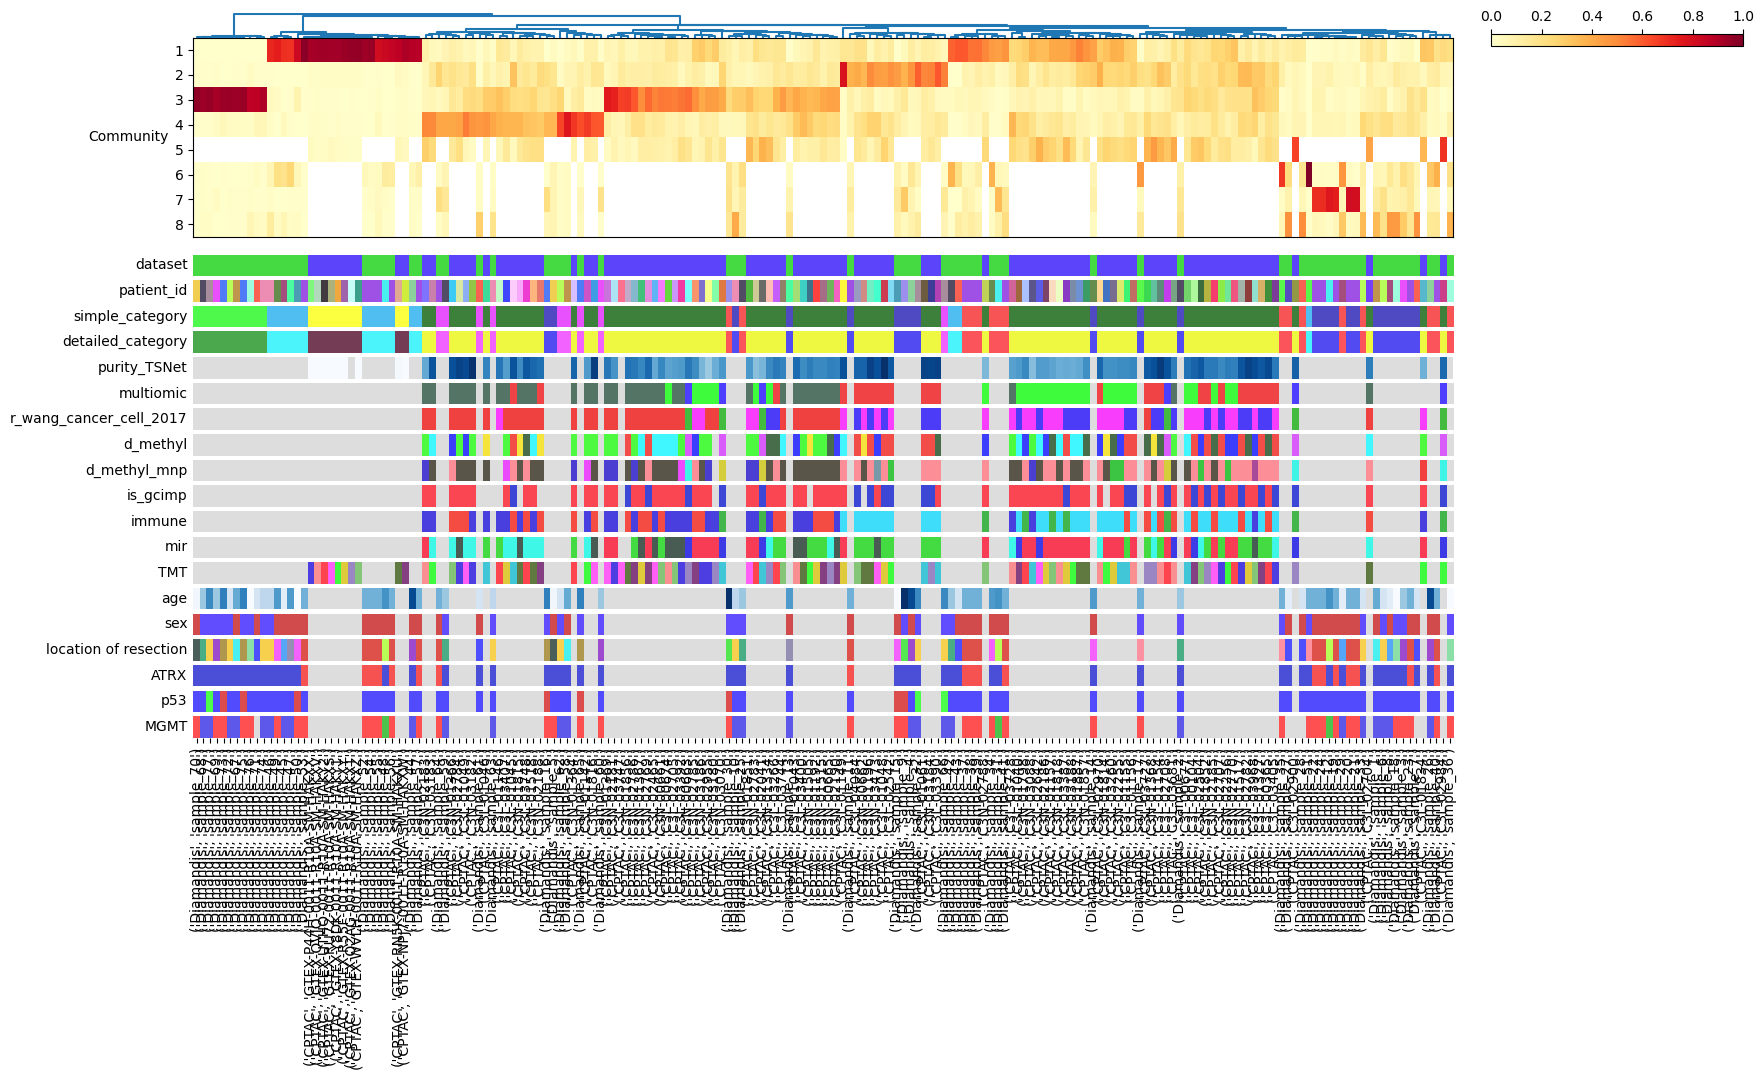

In [34]:
fig = cn.plot_community_usage_heatmap(snsmap, colors, prepend_dataset_colors=True)
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation categorical variables with usage of GEPs, grouped by community

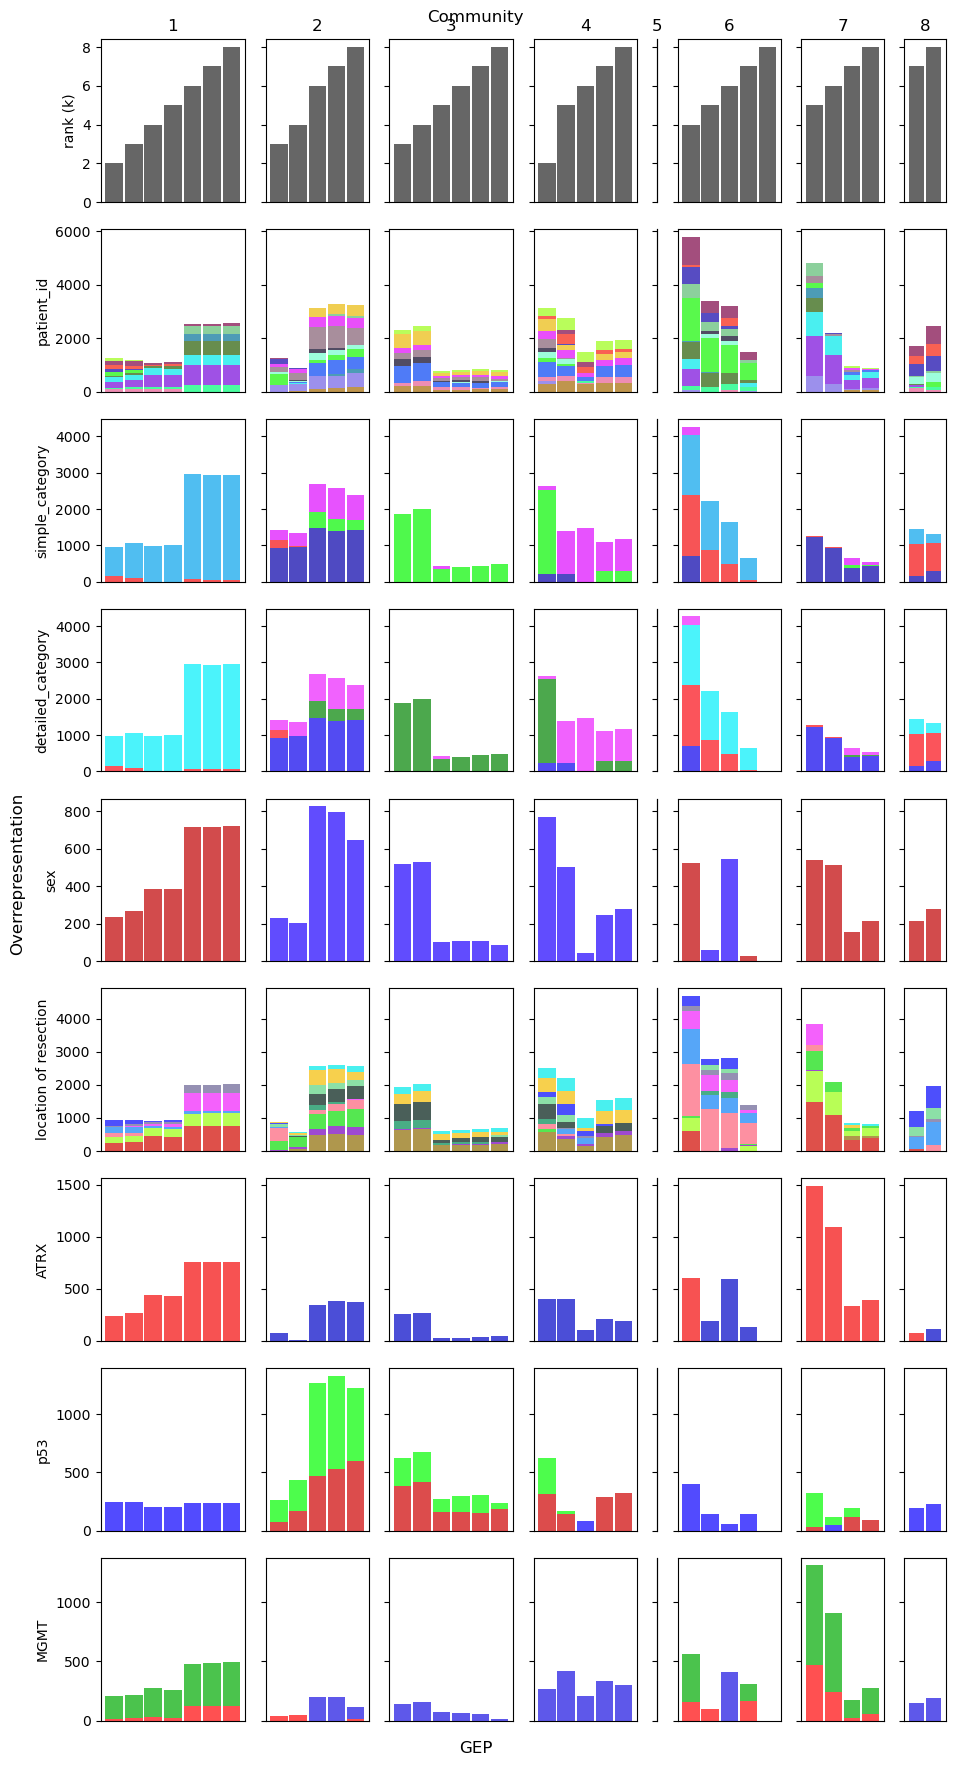

In [35]:
fig = cn.plot_overrepresentation_gep_bar(snsmap, colors, dataset_name="Diamandis")
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation GEPs in each community with continuous variables like `age`

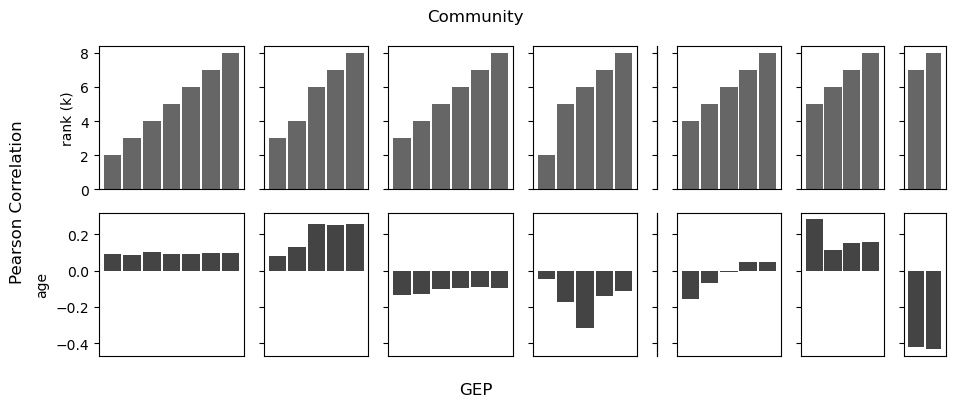

In [36]:
fig = cn.plot_metadata_correlation_gep_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation

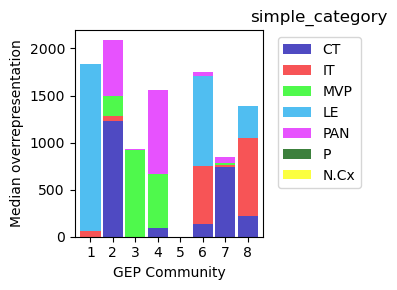

In [37]:
fig = cn.plot_overrepresentation_community_bar(snsmap, colors, layer="simple_category", subset_datasets="Diamandis")

Or, plot it on the network:

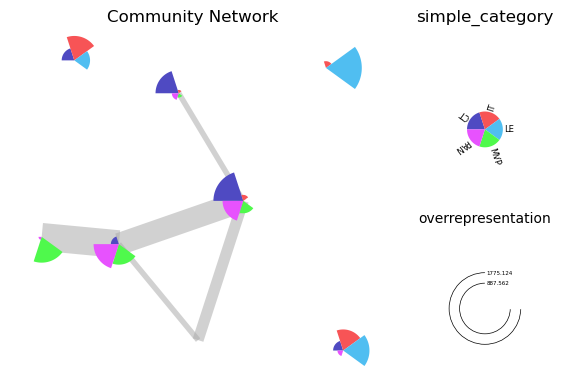

In [38]:
fig = cn.plot_overrepresentation_community_network(snsmap, colors, layer="simple_category", pie_size=0.2, subset_datasets="Diamandis")

# Summarizing correlation with metadata

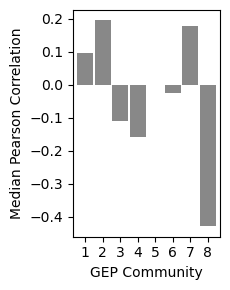

In [39]:
fig = cn.plot_metadata_correlation_community_bar(snsmap, colors, layer="age", subset_datasets="Diamandis")

Or, plot it on the network:

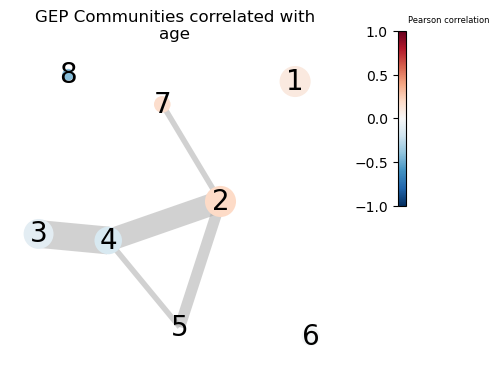

In [40]:
fig = cn.plot_metadata_correlation_community_network(snsmap, colors, layer="age", subset_datasets="Diamandis")

In [9]:
diamandis

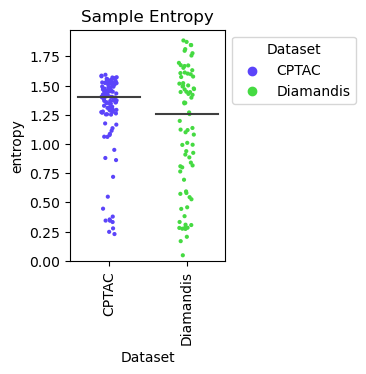

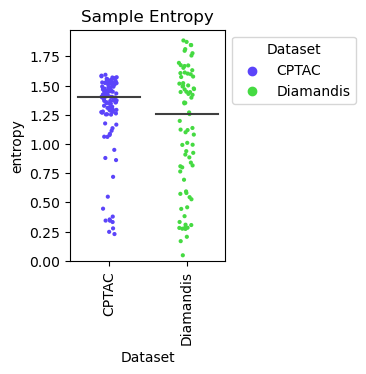

In [41]:
cn.plot_sample_entropy(snsmap, colors)